# Foxglove Data Platform Demo Notebook

This notebook demonstrates retrieving data and events from Foxglove Data Platform.


In [1]:
# Load our API key from our .env file

from dotenv import dotenv_values

config = dotenv_values(".env")
api_key = config["API_KEY"]
api_key

'fox_sk_7fgp0VTlRnjsWGvJ6b5cF4hBDYVNy6Jf'

In [2]:
# Now we can create an instance of our client.

from foxglove.data_platform.client import Client, OutputFormat

client = Client(token=api_key)

In [3]:
# Next let's use the client to list some events.

import pandas as pd
import tabulate

events = client.list_events(
    device_name="Milesbot", limit=5, key="position", value="start"
)
desired_fields = ["id", "metadata", "timestamp"]
filtered_events = [{k: v for k, v in e.items() if k in desired_fields} for e in events]
pd.DataFrame(events, columns=["id", "metadata", "timestamp"])

,id,metadata,timestamp
0,evt_PbkdOL8geyyXLIOr,{'position': 'start'},2018-07-24 03:28:47+00:00


In [4]:
# Now we can download some data from data platform.

import sys
from datetime import datetime, timedelta

start_event = events[-1]
start_time = start_event["timestamp"]
end_time = start_time + timedelta(seconds=1)
device_id = start_event["device_id"]

download_stream = client.download_data(
    device_id=device_id,
    start=start_time,
    end=end_time,
    output_format=OutputFormat.mcap0,
)

data = bytes()
for chunk in download_stream.iter_content(chunk_size=64 * 1024):
    sys.stdout.write(".")
    data += chunk
print()
print(f"read {len(data)} bytes")

....................................................................
read 3296807 bytes


In [7]:
# Let's unpack some schemas, channels, and messages, from our mcap stream.

from io import BytesIO

from genpy import dynamic
from mcap.mcap0.records import Channel, Message, Schema
from mcap.mcap0.stream_reader import StreamReader

reader = StreamReader(BytesIO(data))
channels = {}
schemas = {}
messages = []
msg_types = {}
for record in reader.records:
    if isinstance(record, Schema):
        schemas[record.id] = record
        if not record.name in msg_types:
            msg_type = dynamic.generate_dynamic(record.name, record.data.decode())
            msg_types[record.name] = msg_type[record.name]
    if isinstance(record, Channel):
        channels[record.id] = record
    if isinstance(record, Message):
        channel = channels[record.channel_id]
        schema = schemas[channel.schema_id]
        message = msg_types[schema.name]().deserialize(record.data)
        if schema.name == "sensor_msgs/Imu":
            messages.append(
                {
                    "secs": message.header.stamp.secs,
                    "nsecs": message.header.stamp.nsecs,
                    "x": message.linear_acceleration.x,
                    "y": message.linear_acceleration.y,
                }
            )

pd.DataFrame(messages[0:3])

,secs,nsecs,x,y
0,1532402927,649034000,-0.411290,-0.480808
1,1532402927,659077000,-0.533049,-0.210119
2,1532402927,669063000,-0.738663,-0.400300


<AxesSubplot:>

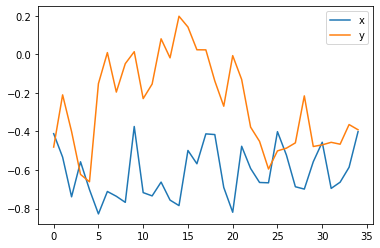

In [6]:
import pandas as pd

frame = pd.DataFrame(messages, columns=["x", "y"])
frame.plot()